In [1]:
# Created 05/17/19 by A.T. (tropiano.4@osu.edu)

# This notebook makes SRG operator evolution figures.

from os import chdir, getcwd
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.linalg import expm
# Scripts made by A.T.
from deuteron import Deuteron
from Figures import figures_functions as ff
from Potentials.vsrg_macos import load_save_potentials as lp
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

__Operator evolution__

* Plotting functions for operator evolution evolving in $\lambda$.

In [2]:
def momentum_projection_operator(q, kvnn, channel, kmax, kmid, ntot, method, generator, lambda_bd=0.00, \
                                 k_magnus=6, ds=1e-5):
    '''Plots a 2 x 2 figure of the momentum projection operator evolving from 10.0 to 1.2 fm^-1.'''
    
    # Arguments
    
    # q (float): Momentum value in fm^-1
    # kvnn (integer): This number specifies the potential
    # channel (string): The partial wave channel ('1S0', '3S1', etc.)
    # kmax (float): Maximum value in the momentum mesh
    # kmid (float): Mid-point value in the momentum mesh
    # ntot (integer): Number of momentum points in mesh
    # method (string): The evolution method 'srg' or 'magnus'
    # generator (string): SRG generator ('Wegner', 'T', 'Block-diag')
    # lambda_bd (float): Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1)
    # k_magnus (integer): Number of terms to include in Magnus sum (for Magnus only)
    # ds (float): Step-size in the flow parameter s (for Magnus only)
    
    # Current working directory
    cwd = getcwd()
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 4.0
    
    # Load initial Hamiltonian, momentum, and weights
    H0_matrix = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    gp, gw = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result 
    row, col = np.meshgrid(gp*np.sqrt(gw), gp*np.sqrt(gw))
    
    # Pick the nearest value of q if q isn't exactly in gp
    if not( q in gp ):
        
        k_difference_array = abs(gp-q)
        k_difference_min = min(k_difference_array)
        q_index = list(k_difference_array).index(k_difference_min)
        # Reset q to an actual value in k_array mesh (this is the closest value to entered q)
        q = gp[q_index]    
    
    # Initialize deuteron class 
    D = Deuteron(H0_matrix, gp, gw)
    
    # Loop over lambda values in lambdas and save evolved operators to dictionary where key = lambda
    lambdas = [10.0, 2.8, 2.0, 1.5]
    #lambdas = [10.0, 2.8, 2.0, 1.2]
    d = {}
    
    for lamb in lambdas:
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        if method == 'srg':
            
            # Must input evolved matrix
            Hs_matrix = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method, generator, lamb, lambda_bd)
            Us_matrix = SRG_unitary_transformation(H0_matrix, Hs_matrix)
            
        # Magnus loads Omega(s) to compute U(s) = exp^Omega(s)
        elif method == 'magnus':
            
            # Switch to step-size of 1e-6 (or smaller) automatically if lambda = 10 fm^-1
            if lamb == 10.0 and ds > 1e-6:
                step_size = 1e-6
            else:
                step_size = ds
            
            Os_matrix = lp.load_omega(kvnn, channel, kmax, kmid, ntot, generator, lamb, lambda_bd, k_magnus, \
                                      step_size)
            Us_matrix = expm(Os_matrix)
        
        # Evolved momentum projection operator in 3S1 channel divided by k_i * k_j * sqrt( w_i * w_j ) 
        # for mesh-independent result
        momentum_proj_operator = D.momentum_proj_operator(q, U=Us_matrix)[:120,:120]/row/col
        
        # Interpolate the operator for better looking figure
        k_array, interpolated_operator = ff.interpolate_matrix(gp, momentum_proj_operator, axes_max)
        # Enter into dictionary
        d[lamb] = interpolated_operator
    
    # Limits of color bar in fm
    mx = 0.005
    mn = -0.005
    
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Fontsize for labels
    axes_label_size = 20
    axes_tick_size = 18
    lambda_size = 22
    colorbar_tick_size = 18
        
    # Location of labels
    if q < axes_max/2:
        q_loc = 7
        lamb_loc = 3
    else:
        q_loc = 2
        lamb_loc = 3
        
    # Step-size in labeling tick marks
    stepsize = 1.0
    
    # Plot 2 x 2 figure     
    plt.close('all')
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(11,10))
    
    # lambda = 10.0 fm^-1
    ax1.pcolormesh(k_array, k_array, d[lambdas[0]], vmin=mn, vmax=mx, cmap=color_style)
    ax1.set_xlim([0,axes_max])
    ax1.set_ylim([0,axes_max])
    ax1.set_xlabel(r"$k \/ \/ [fm^{-1}]$", fontsize=axes_label_size)
    ax1.set_ylabel(r"$k' \/ \/ [fm^{-1}]$", fontsize=axes_label_size)
    ax1.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax1.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=True, labelsize=axes_tick_size)
    anchored_text_1 = AnchoredText(r'$q=%.2f\/fm^{-1}$'%q, prop=dict(size=22), loc=q_loc)
    ax1.add_artist(anchored_text_1)
    anchored_text_2 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[0], prop=dict(size=lambda_size), loc=lamb_loc)
    ax1.add_artist(anchored_text_2)
    
    # lambda = 2.8 fm^-1
    ax2.pcolormesh(k_array, k_array, d[lambdas[1]], vmin=mn, vmax=mx, cmap=color_style)
    ax2.set_xlim([0,axes_max])
    ax2.set_ylim([0,axes_max])
    ax2.set_xlabel(r"$k \/ \/ [fm^{-1}]$", fontsize=axes_label_size)
    ax2.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax2.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    ax2.tick_params(labeltop=True, labelsize=axes_tick_size)
    anchored_text_3 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[1], prop=dict(size=lambda_size), loc=lamb_loc)
    ax2.add_artist(anchored_text_3)
    
    # lambda = 2.0 fm^-1
    ax3.pcolormesh(k_array, k_array, d[lambdas[2]], vmin=mn, vmax=mx, cmap=color_style)
    ax3.set_xlim([0,axes_max])
    ax3.set_ylim([0,axes_max])
    ax3.set_ylabel(r"$k \/ \/ [fm^{-1}]$", fontsize=axes_label_size)
    ax3.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax3.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax3.xaxis.tick_top()
    ax3.tick_params(labeltop=False, labelsize=axes_tick_size)
    anchored_text_4 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[2], prop=dict(size=lambda_size), loc=lamb_loc)
    ax3.add_artist(anchored_text_4)

    # lambda = 1.2 fm^-1
    c = ax4.pcolormesh(k_array, k_array, d[lambdas[3]], vmin=mn, vmax=mx, cmap=color_style)
    ax4.set_xlim([0,axes_max])
    ax4.set_ylim([0,axes_max])
    ax4.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax4.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax4.xaxis.tick_top()
    ax4.tick_params(labeltop=False, labelsize=axes_tick_size)
    anchored_text_5 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[3], prop=dict(size=lambda_size), loc=lamb_loc)
    ax4.add_artist(anchored_text_5)

    plt.gca().invert_yaxis()
    f.subplots_adjust(hspace=0.1, wspace=0.1)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
    # Name of jpeg file
    q_string = 'q%.2f'%q
    q_string = q_string[:2]+','+q_string[3:]
    if generator == 'Block-diag':
        name = 'momentum_projection_operator_%s_kvnn%s_%s_%s_%s%.2f'%(q_string, kvnn, channel, method, generator, \
                                                                      lambda_bd)
    else:
        name = 'momentum_projection_operator_%s_kvnn%s_%s_%s_%s'%(q_string, kvnn, channel, method, generator)
        
    # Save figure
    folder = ff.current_date() # Gets current month and year
    chdir('Figures/%s'%folder)
    f.savefig(name+'.jpg', bbox_inches='tight')
    chdir(cwd)      

In [3]:
def deuteron_momentum_distribution(kvnn, kmax, kmid, ntot, method, generator, lamb, lambda_bd=0.00, \
                                   k_magnus=6, ds=1e-5):
    '''Plots a 1 x 1 figure of |psi_d(k)|^2 [fm^3] as a function of momentum k [fm^-1] with psi_d(lambda) from 
    the bare Hamiltonian and psi_d(lambda) from the evolved Hamiltonian at a given value of lambda.'''
    
    # Arguments
    
    # kvnn (integer): This number specifies the potential
    # channel (string): The partial wave channel ('1S0', '3S1', etc.)
    # kmax (float): Maximum value in the momentum mesh
    # kmid (float): Mid-point value in the momentum mesh
    # ntot (integer): Number of momentum points in mesh
    # method (string): The evolution method ('srg' or 'magnus')
    # generator (string): SRG generator ('Wegner', 'T', 'Block-diag')
    # lamb (float): Evolution parameter lambda in units fm^-1
    # lambda_bd (float): Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1)
    # k_magnus (integer): Number of terms to include in Magnus sum
    # ds (float): Step-size in the flow parameter s
    
    cwd = getcwd()
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    
    # Load initial Hamiltonian, momentum, and weights
    H0_matrix = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    gp, gw = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Initialize deuteron class 
    D = Deuteron(H0_matrix, gp, gw)
    
    # Load unitary transformation
    # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
    if method == 'srg':
            
        # Must input evolved matrix
        Hs_matrix = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method, generator, lamb, lambda_bd)
        Us_matrix = SRG_unitary_transformation(H0_matrix, Hs_matrix)
            
    # Magnus loads Omega(s) to compute U(s) = exp^Omega(s)
    elif method == 'magnus':
            
        # Switch to step-size of 1e-6 (or smaller) automatically if lambda = 10 fm^-1
        if lamb == 10.0 and ds > 1e-6:
            step_size = 1e-6
        else:
            step_size = ds
            
        Os_matrix = lp.load_omega(kvnn, channel, kmax, kmid, ntot, generator, lamb, lambda_bd, k_magnus, step_size)
        Us_matrix = expm(Os_matrix)
        
    # Compute initial and evolved wave functions in S and D wave components: u and w
    u_0, w_0 = D.wave_func()
    u_s, w_s = D.wave_func(U=Us_matrix)
    # Initial and evolved momentum distribution (divide by momenta and weights for mesh-independent result)
    phi_squared_0 = ( u_0**2 + w_0**2 ) / ( gp**2 * gw )
    phi_squared_s = ( u_s**2 + w_s**2 ) / ( gp**2 * gw )

    # Limits of x and y axes
    xlim = [0.0,4.0]
    ylim = [1e-5,1e3]
    
    # Generator label
    if generator == 'Block-diag':
        generator_label = r'$G=H_{BD}$'+'\n'+r'$\Lambda=%.2f \/ fm^{-1}$'%lambda_bd
    elif generator == 'T':
        generator_label = r'$G=T_{rel}$'
    elif generator == 'Wegner':
        generator_label = r'$G=H_{D}$'
    
    # Fontsize for labels
    legend_label_size = 16
    x_label_size = 18
    y_label_size = 20
    generator_label_size = 20
    
    # Plot psi^2 [fm^3] as a function of k [fm^-1]
    plt.close('all')
    
    f, ax = plt.subplots()
    
    ax.semilogy(gp, phi_squared_s, 'r-', linewidth=1.5, label=r'$\lambda=%.1f \/ \/ fm^{-1}$'%lamb)
    ax.semilogy(gp, phi_squared_0, 'k:', label=r'$\lambda=\infty \/ \/ fm^{-1}$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc=1, frameon=False, fontsize=legend_label_size)
    ax.set_xlabel(r'$k \/ [fm^{-1}]$', fontsize=x_label_size)
    ax.set_ylabel(r'$\phi^2 \/ \/ [fm^3]$', fontsize=y_label_size)
    anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size), loc=3, frameon=False)
    ax.add_artist(anchored_text)
    
    # Name of jpeg file
    if generator == 'Block-diag':
        name = 'deuteron_momentum_distribution_kvnn%s_%s_%s%.2f_lamb%.1f'%(kvnn, method, generator, lambda_bd, lamb)
    else:
        name = 'deuteron_momentum_distribution_kvnn%s_%s_%s_lamb%.1f'%(kvnn, method, generator, lamb)
        
    # Save figure
    folder = ff.current_date() # Gets current month and year
    chdir('Figures/%s'%folder)
    f.savefig(name+'.pdf', bbox_inches='tight')
    chdir(cwd)  

In [4]:
def r2_operator(kvnn, channel, kmax, kmid, ntot, method, generator, lambda_bd=0.00, k_magnus=6, ds=1e-5):
    '''Plots a 2 x 2 figure of the r^2 operator evolving from 10.0 to 1.2 fm^-1.'''
    
    # Arguments
    
    # kvnn (integer): This number specifies the potential
    # channel (string): The partial wave channel ('1S0', '3S1', etc.)
    # kmax (float): Maximum value in the momentum mesh
    # kmid (float): Mid-point value in the momentum mesh
    # ntot (integer): Number of momentum points in mesh
    # method (string): The evolution method 'srg' or 'magnus'
    # generator (string): SRG generator ('Wegner', 'T', 'Block-diag')
    # lambda_bd (float): Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1)
    # k_magnus (integer): Number of terms to include in Magnus sum (for Magnus only)
    # ds (float): Step-size in the flow parameter s (for Magnus only)
    
    # Current working directory
    cwd = getcwd()
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 0.4
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min,r_max+dr,dr)
    
    # Load initial Hamiltonian, momentum, and weights
    H0_matrix = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    gp, gw = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result 
    row, col = np.meshgrid(gp*np.sqrt(gw), gp*np.sqrt(gw)) 
    
    # Initialize deuteron class 
    D = Deuteron(H0_matrix, gp, gw, r_array, dr)
    
    # Loop over lambda values in lambdas and save evolved operators to dictionary where key = lambda
    lambdas = [10.0, 2.8, 2.0, 1.5]
    #lambdas = [10.0, 2.8, 2.0, 1.2]
    d = {}
    
    for lamb in lambdas:
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        if method == 'srg':
            
            # Must input evolved matrix
            Hs_matrix = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method, generator, lamb, lambda_bd)
            Us_matrix = SRG_unitary_transformation(H0_matrix, Hs_matrix)
            
        # Magnus loads Omega(s) to compute U(s) = exp^Omega(s)
        elif method == 'magnus':
            
            # Switch to step-size of 1e-6 (or smaller) automatically if lambda = 10 fm^-1
            if lamb == 10.0 and ds > 1e-6:
                step_size = 1e-6
            else:
                step_size = ds
            
            Os_matrix = lp.load_omega(kvnn, channel, kmax, kmid, ntot, generator, lamb, lambda_bd, k_magnus, \
                                      step_size)
            Us_matrix = expm(Os_matrix)
        
        # Evolved r^2 operator
        r2_operator = D.r2_operator(U=Us_matrix)[:120,:120]/row/col
        #r2_operator = D.r2_operator(U=Us_matrix)[:120,:120]
        
        # Interpolate the operator for better looking figure
        k_array, r2_operator_interpolated = ff.interpolate_matrix(gp, r2_operator, axes_max)
        # Enter into dictionary
        d[lamb] = r2_operator_interpolated
    
    # Limits of color bar in fm
    mx = 1e6
    mn = -1e6
    levels = list(np.linspace(mn,mx,9)) # Number of tick marks/labels on color bar
    
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Fontsize for labels
    axes_label_size = 20
    axes_tick_size = 16
    lambda_size = 22
    colorbar_tick_size = 18
        
    # Location of labels
    lamb_loc = 3
        
    # Step-size in labeling tick marks
    stepsize = 0.1
    
    # Plot 2 x 2 figure     
    plt.close('all')
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(11,10))
    
    # lambda = 10.0 fm^-1
    ax1.pcolormesh(k_array, k_array, d[lambdas[0]], vmin=mn, vmax=mx, cmap=color_style)
    ax1.set_xlim([0,axes_max])
    ax1.set_ylim([0,axes_max])
    ax1.set_xlabel(r"$k \/ \/ [fm^{-1}]$", fontsize=axes_label_size)
    ax1.set_ylabel(r"$k' \/ \/ [fm^{-1}]$", fontsize=axes_label_size)
    ax1.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax1.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=True, labelsize=axes_tick_size)
    anchored_text_1 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[0], prop=dict(size=lambda_size), loc=lamb_loc)
    ax1.add_artist(anchored_text_1)
    
    # lambda = 2.8 fm^-1
    ax2.pcolormesh(k_array, k_array, d[lambdas[1]], vmin=mn, vmax=mx, cmap=color_style)
    ax2.set_xlim([0,axes_max])
    ax2.set_ylim([0,axes_max])
    ax2.set_xlabel(r"$k \/ \/ [fm^{-1}]$", fontsize=axes_label_size)
    ax2.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax2.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    ax2.tick_params(labeltop=True, labelsize=axes_tick_size)
    anchored_text_2 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[1], prop=dict(size=lambda_size), loc=lamb_loc)
    ax2.add_artist(anchored_text_2)
    
    # lambda = 2.0 fm^-1
    ax3.pcolormesh(k_array, k_array, d[lambdas[2]], vmin=mn, vmax=mx, cmap=color_style)
    ax3.set_xlim([0,axes_max])
    ax3.set_ylim([0,axes_max])
    ax3.set_ylabel(r"$k \/ \/ [fm^{-1}]$", fontsize=axes_label_size)
    ax3.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax3.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax3.xaxis.tick_top()
    ax3.tick_params(labeltop=False, labelsize=axes_tick_size)
    anchored_text_3 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[2], prop=dict(size=lambda_size), loc=lamb_loc)
    ax3.add_artist(anchored_text_3)

    # lambda = 1.2 fm^-1
    c = ax4.pcolormesh(k_array, k_array, d[lambdas[3]], vmin=mn, vmax=mx, cmap=color_style)
    ax4.set_xlim([0,axes_max])
    ax4.set_ylim([0,axes_max])
    ax4.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax4.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax4.xaxis.tick_top()
    ax4.tick_params(labeltop=False, labelsize=axes_tick_size)
    anchored_text_4 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[3], prop=dict(size=lambda_size), loc=lamb_loc)
    ax4.add_artist(anchored_text_4)

    plt.gca().invert_yaxis()
    f.subplots_adjust(hspace=0.1, wspace=0.1)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
    # Name of jpeg file
    if generator == 'Block-diag':
        name = 'r2_operator_kvnn%s_%s_%s_%s%.2f'%(kvnn, channel, method, generator, lambda_bd)
    else:
        name = 'r2_operator_kvnn%s_%s_%s_%s'%(kvnn, channel, method, generator)
        
    # Save figure
    folder = ff.current_date() # Gets current month and year
    chdir('Figures/%s'%folder)
    f.savefig(name+'.jpg', bbox_inches='tight')
    chdir(cwd)      

__Run functions in the cell(s) below:__

In [8]:
# Specifications for potential and evolution method (see description of arguments in functions above)

channel = '3S1'
ntot = 120

# RKE semi-local potential 
#kmax = 8.0
#kmid = 2.0

# EM N3LO non-local potential
#kmax = 30.0
#kmid = 4.0

# Gezerlis et al N2LO local potential
kmax = 10.0
kmid = 2.0

# SRG evolved
method = 'srg'
lamb = 1.5

# Magnus evolved
k_magnus = 6
ds = 1e-5

In [6]:
# Plot momentum projection operators

# Project to q = 3 fm^-1
q = 3.0

# N3LO 400 MeV cutoff
#momentum_projection_operator(q, 105, channel, kmax, kmid, ntot, method, 'Wegner', k_magnus=k_magnus, ds=ds)

# N3LO 450 MeV cutoff
#momentum_projection_operator(q, 106, channel, kmax, kmid, ntot, method, 'Wegner', k_magnus=k_magnus, ds=ds)

# N3LO 500 MeV cutoff
#momentum_projection_operator(q, 107, channel, kmax, kmid, ntot, method, 'Wegner', k_magnus=k_magnus, ds=ds)

# N3LO at Lambda = 500 MeV but with block-diagonal generator at lambda_bd = 2 fm^-1
#momentum_projection_operator(q, 107, channel, kmax, kmid, ntot, 'srg', 'Block-diag', lambda_bd=2.00)

# N4LO at Lambda = 450 MeV
#momentum_projection_operator(q, 111, channel, kmax, kmid, ntot, method, 'Wegner', k_magnus=k_magnus, ds=ds)

# N4LO at Lambda = 500 MeV (this is the one used in the NUCLEI highlight)
#momentum_projection_operator(q, 112, channel, kmax, kmid, ntot, method, 'Wegner', k_magnus=k_magnus, ds=ds)

# N4LO at Lambda = 500 MeV but with block-diagonal generator at lambda_bd = 1 fm^-1
#momentum_projection_operator(q, 112, channel, kmax, kmid, ntot, 'srg', 'Block-diag', lambda_bd=1.00)

# N4LO at Lambda = 500 MeV but with block-diagonal generator at lambda_bd = 2 fm^-1
#momentum_projection_operator(q, 112, channel, kmax, kmid, ntot, 'srg', 'Block-diag', lambda_bd=2.00)

# N4LO at Lambda = 500 MeV but with block-diagonal generator at lambda_bd = 3 fm^-1
#momentum_projection_operator(q, 112, channel, kmax, kmid, ntot, 'srg', 'Block-diag', lambda_bd=3.00)

# N4LO at Lambda = 500 MeV but with block-diagonal generator at lambda_bd = 4 fm^-1
#momentum_projection_operator(q, 112, channel, kmax, kmid, ntot, 'srg', 'Block-diag', lambda_bd=4.00)

# EM N3LO
#momentum_projection_operator(q, 10, channel, 30.0, 4.0, 120, 'srg', 'Block-diag', lambda_bd=2.00)

# Gezerlis et al N2LO local at R_0 = 1.0 fm
#momentum_projection_operator(q, 222, channel, kmax, kmid, ntot, 'srg', 'Wegner')

# Gezerlis et al N2LO local at R_0 = 1.2 fm
#momentum_projection_operator(q, 224, channel, kmax, kmid, ntot, 'srg', 'Wegner')

# Gezerlis et al N2LO local at R_0 = 1.0 fm but with block-diagonal generator at lambda_bd = 2 fm^-1
#momentum_projection_operator(q, 222, channel, kmax, kmid, ntot, 'srg', 'Block-diag', lambda_bd=2.00)

# Note: the following potentials below do not have SRG files at lambda = 1.5 fm^-1 so you need to change that to
# 1.2 fm^-1 within the function

# AV18
#momentum_projection_operator(q, 6, channel, 30.0, 4.0, 120, 'srg', 'Wegner')

# EM N3LO
#momentum_projection_operator(q, 10, channel, 30.0, 4.0, 120, 'srg', 'Wegner')

# Non-local LO Lambda = 4 fm^-1
#momentum_projection_operator(q, 900, channel, 30.0, 4.0, 120, 'srg', 'Wegner')

# Non-local LO Lambda = 9 fm^-1
#momentum_projection_operator(q, 901, channel, 30.0, 4.0, 120, 'srg', 'Wegner')

# Non-local LO Lambda = 20 fm^-1
#momentum_projection_operator(q, 902, channel, 30.0, 4.0, 120, 'srg', 'Wegner')

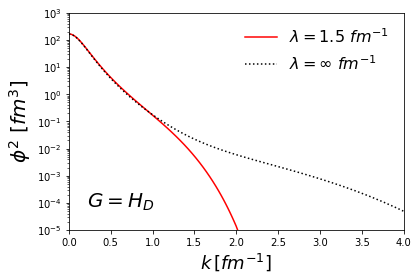

In [9]:
# Plot deuteron momentum distributions

# N4LO at Lambda = 500 MeV with Wegner generator
#deuteron_momentum_distribution(112, kmax, kmid, ntot, 'magnus', 'Wegner', lamb)

# N4LO at Lambda = 500 MeV with block-diagonal generator at lambda_bd = 2 fm^-1
#deuteron_momentum_distribution(112, kmax, kmid, ntot, method, 'Block-diag', lamb, lambda_bd=1.00)

# N4LO at Lambda = 500 MeV with block-diagonal generator at lambda_bd = 2 fm^-1
#deuteron_momentum_distribution(112, kmax, kmid, ntot, method, 'Block-diag', lamb, lambda_bd=2.00)

# N4LO at Lambda = 500 MeV with block-diagonal generator at lambda_bd = 3 fm^-1
#deuteron_momentum_distribution(112, kmax, kmid, ntot, method, 'Block-diag', lamb, lambda_bd=3.00)

# N4LO at Lambda = 500 MeV with block-diagonal generator at lambda_bd = 4 fm^-1
#deuteron_momentum_distribution(112, kmax, kmid, ntot, method, 'Block-diag', lamb, lambda_bd=4.00)

# N4LO at Lambda = 500 MeV with block-diagonal generator at lambda_bd = 2 fm^-1 and lamb = 2.8
#deuteron_momentum_distribution(112, kmax, kmid, ntot, method, 'Block-diag', 2.8, lambda_bd=2.00)

# Gezerlis et al N2LO local at R_0 = 1.0 fm
deuteron_momentum_distribution(222, kmax, kmid, ntot, method, 'Wegner', lamb)

# Gezerlis et al N2LO local at R_0 = 1.2 fm
#deuteron_momentum_distribution(224, kmax, kmid, ntot, method, 'Wegner', lamb)

# Gezerlis et al N2LO local at R_0 = 1.0 fm but with block-diagonal generator at lambda_bd = 2 fm^-1
#deuteron_momentum_distribution(222, kmax, kmid, ntot, method, 'Block-diag', lamb, lambda_bd=2.00)

In [ ]:
# Plot r^2 operators

# N4LO at Lambda = 500 MeV (default)
#r2_operator(112, channel, kmax, kmid, ntot, 'magnus', 'Wegner', k_magnus=k_magnus, ds=ds)

# N4LO at Lambda = 500 MeV with block-diagonal generator at lambda_bd = 2 fm^-1
#r2_operator(112, channel, kmax, kmid, ntot, 'srg', 'Block-diag', lambda_bd=2.00)

In [ ]:
# Plot r^2 integrands